<a href="https://colab.research.google.com/github/teethavattcp/teethavat_data_sci_port/blob/main/Projects/01_PM_2.5_Forecasting_with_LSTM_RNN/PM2.5_Forecasting_BKK_02_RNN_v2_wo_exo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building RNN forecasting model

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns;
import math

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

from keras import optimizers
from keras.models import Sequential

from keras.layers import LSTM
from keras.layers.core import Dense, Dropout, Activation

from keras.callbacks import ModelCheckpoint

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Join dataframe

In [ ]:
df_train_pm25 = pd.read_csv('/content/drive/MyDrive/DATA_SCI_SKILL/DATA SCI ENG/Final_Proj_1/train_pm25_BKK.csv',sep=',')

## Manage Training dataset

In [ ]:
df_train_pm25

,Time,PM2.5(µg/m3)
0,2017-07-01 01:00:00,10.0
1,2017-07-01 04:00:00,15.0
2,2017-07-01 07:00:00,23.0
3,2017-07-01 10:00:00,22.0
4,2017-07-01 13:00:00,14.0
...,...,...
8763,2020-06-30 10:00:00,14.0
8764,2020-06-30 13:00:00,12.0
8765,2020-06-30 16:00:00,9.0
8766,2020-06-30 19:00:00,15.0


In [ ]:
df_train_pm25.isnull().sum()

Time            0
PM2.5(µg/m3)    0
dtype: int64

### Import exogeneous data

In [ ]:
df_train_temp = pd.read_csv('/content/drive/MyDrive/DATA_SCI_SKILL/DATA SCI ENG/Final_Proj_1/datasci_dataset_2022/BKK/train/bkk_temp_surface.csv',sep=',')

In [ ]:
df_train_temp

,date_time,temp
0,07-01-17 1:00,27.9
1,07-01-17 4:00,27.4
2,07-01-17 7:00,28.0
3,07-01-17 10:00,31.1
4,07-01-17 13:00,33.3
...,...,...
8763,6/30/2020 10:00,30.8
8764,6/30/2020 13:00,32.0
8765,6/30/2020 16:00,32.1
8766,6/30/2020 19:00,30.3


In [ ]:
df_train_temp.isnull().sum()

date_time    0
temp         0
dtype: int64

In [ ]:
df_train_wind = pd.read_csv('/content/drive/MyDrive/DATA_SCI_SKILL/DATA SCI ENG/Final_Proj_1/datasci_dataset_2022/BKK/train/bkk_weather_wind.csv',sep=',')
df_train_wind

,date_time,wind speed,wind dir
0,2017-07-01 01:00:00,16,260
1,2017-07-01 04:00:00,16,255
2,2017-07-01 07:00:00,17,235
3,2017-07-01 10:00:00,18,240
4,2017-07-01 13:00:00,18,255
...,...,...,...
8763,2020-06-30 10:00:00,24,250
8764,2020-06-30 13:00:00,23,250
8765,2020-06-30 16:00:00,37,255
8766,2020-06-30 19:00:00,36,265


In [ ]:
df_train_wind.isnull().sum()

date_time     0
wind speed    0
wind dir      0
dtype: int64

In [ ]:
df_train_rh = pd.read_csv('/content/drive/MyDrive/DATA_SCI_SKILL/DATA SCI ENG/Final_Proj_1/train_all_rescrap_BKK.csv',sep=',')
del df_train_rh['Unnamed: 0']
df_train_rh

,Time (UTC),Surface Relative Humidity (%)
0,2017/06/30 00:00:00,74
1,2017/06/30 03:00:00,62
2,2017/06/30 06:00:00,55
3,2017/06/30 09:00:00,55
4,2017/06/30 12:00:00,72
...,...,...
8771,2020/06/30 09:00:00,61
8772,2020/06/30 12:00:00,69
8773,2020/06/30 15:00:00,69
8774,2020/06/30 18:00:00,68


### Eliminate first 6 columns and last 2 columns

In [ ]:
df_train_rh.drop([0,1,2,3,4,5,8774,8775],axis=0, inplace = True)
df_train_rh

,Time (UTC),Surface Relative Humidity (%)
6,2017/06/30 18:00:00,79
7,2017/06/30 21:00:00,80
8,2017/07/01 00:00:00,75
9,2017/07/01 03:00:00,59
10,2017/07/01 06:00:00,51
...,...,...
8769,2020/06/30 03:00:00,61
8770,2020/06/30 06:00:00,60
8771,2020/06/30 09:00:00,61
8772,2020/06/30 12:00:00,69


In [ ]:
df_train_rh = df_train_rh.copy().reset_index()
df_train_rh = df_train_rh[['Time (UTC)','Surface Relative Humidity (%)']]
df_train_rh

,Time (UTC),Surface Relative Humidity (%)
0,2017/06/30 18:00:00,79
1,2017/06/30 21:00:00,80
2,2017/07/01 00:00:00,75
3,2017/07/01 03:00:00,59
4,2017/07/01 06:00:00,51
...,...,...
8763,2020/06/30 03:00:00,61
8764,2020/06/30 06:00:00,60
8765,2020/06/30 09:00:00,61
8766,2020/06/30 12:00:00,69


### Join columns

In [ ]:
df_train = pd.concat([df_train_pm25, df_train_wind, df_train_temp,df_train_rh],axis=1)
df_train

,Time,PM2.5(µg/m3),date_time,wind speed,wind dir,date_time,temp,Time (UTC),Surface Relative Humidity (%)
0,2017-07-01 01:00:00,10.0,2017-07-01 01:00:00,16,260,07-01-17 1:00,27.9,2017/06/30 18:00:00,79
1,2017-07-01 04:00:00,15.0,2017-07-01 04:00:00,16,255,07-01-17 4:00,27.4,2017/06/30 21:00:00,80
2,2017-07-01 07:00:00,23.0,2017-07-01 07:00:00,17,235,07-01-17 7:00,28.0,2017/07/01 00:00:00,75
3,2017-07-01 10:00:00,22.0,2017-07-01 10:00:00,18,240,07-01-17 10:00,31.1,2017/07/01 03:00:00,59
4,2017-07-01 13:00:00,14.0,2017-07-01 13:00:00,18,255,07-01-17 13:00,33.3,2017/07/01 06:00:00,51
...,...,...,...,...,...,...,...,...,...
8763,2020-06-30 10:00:00,14.0,2020-06-30 10:00:00,24,250,6/30/2020 10:00,30.8,2020/06/30 03:00:00,61
8764,2020-06-30 13:00:00,12.0,2020-06-30 13:00:00,23,250,6/30/2020 13:00,32.0,2020/06/30 06:00:00,60
8765,2020-06-30 16:00:00,9.0,2020-06-30 16:00:00,37,255,6/30/2020 16:00,32.1,2020/06/30 09:00:00,61
8766,2020-06-30 19:00:00,15.0,2020-06-30 19:00:00,36,265,6/30/2020 19:00,30.3,2020/06/30 12:00:00,69


In [ ]:
df_train = df_train[['Time','PM2.5(µg/m3)','wind speed','wind dir','temp','Surface Relative Humidity (%)']]

df_train.columns = ['Time','PM2.5(µg/m3)','Wind Speed (km/h)','Wind Direction (°)','Surface Temperature (°C)','Surface Relative Humidity (%)']
df_train['Time'] = pd.to_datetime(df_train['Time'])
df_train = df_train.set_index('Time')

df_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,PM2.5(µg/m3),Wind Speed (km/h),Wind Direction (°),Surface Temperature (°C),Surface Relative Humidity (%)
Time,,,,,
2017-07-01 01:00:00,10.0,16,260,27.9,79
2017-07-01 04:00:00,15.0,16,255,27.4,80
2017-07-01 07:00:00,23.0,17,235,28.0,75
2017-07-01 10:00:00,22.0,18,240,31.1,59
2017-07-01 13:00:00,14.0,18,255,33.3,51
...,...,...,...,...,...
2020-06-30 10:00:00,14.0,24,250,30.8,61
2020-06-30 13:00:00,12.0,23,250,32.0,60
2020-06-30 16:00:00,9.0,37,255,32.1,61


### Re-EDA

In [ ]:
df_train.isnull().sum()

PM2.5(µg/m3)                     0
Wind Speed (km/h)                0
Wind Direction (°)               0
Surface Temperature (°C)         0
Surface Relative Humidity (%)    0
dtype: int64

In [ ]:
df_train.describe()

,PM2.5(µg/m3),Wind Speed (km/h),Wind Direction (°),Surface Temperature (°C),Surface Relative Humidity (%)
count,8768.000000,8768.000000,8768.00000,8768.000000,8768.000000
mean,27.227161,20.479813,167.61120,29.810014,62.183736
std,15.244270,13.030356,92.23499,2.652939,10.993569
min,3.000000,0.000000,0.00000,17.200000,24.000000
25%,17.000000,11.000000,80.00000,28.000000,54.000000
50%,23.000000,17.000000,155.00000,29.600000,63.000000
75%,34.000000,27.000000,260.00000,31.600000,71.000000
max,130.000000,85.000000,360.00000,38.100000,91.000000


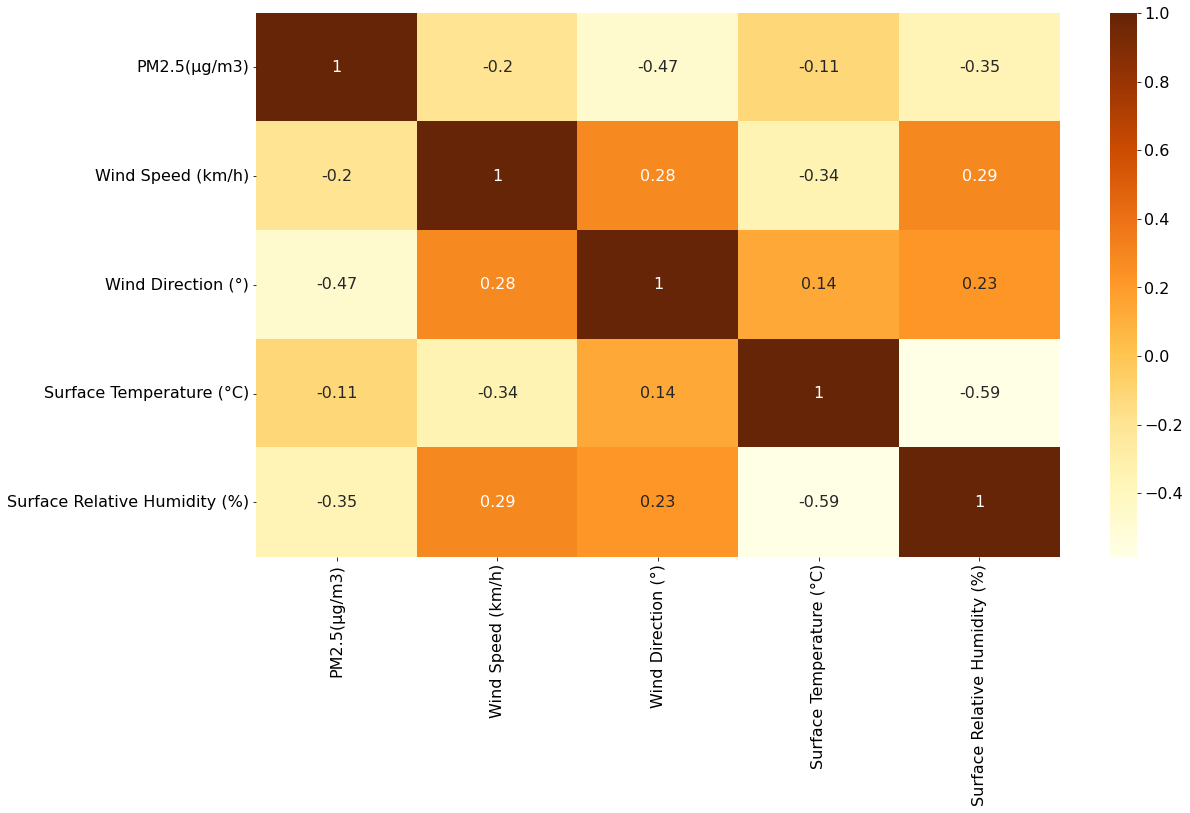

In [ ]:
plt.figure(figsize = (18,10))
plt.rcParams.update({'font.size': 16})
sns.heatmap(df_train[['PM2.5(µg/m3)','Wind Speed (km/h)','Wind Direction (°)','Surface Temperature (°C)','Surface Relative Humidity (%)']].corr(), annot =True, cmap = 'YlOrBr') 

No correlation between each independent variables

## Manage Testing Dataset

In [ ]:
df_test_pm25 = pd.read_csv('/content/drive/MyDrive/DATA_SCI_SKILL/DATA SCI ENG/Final_Proj_1/test_pm25_BKK.csv',sep=',')

In [ ]:
df_test_pm25

,Time,PM2.5(µg/m3)
0,2020-07-01 01:00:00,8.0
1,2020-07-01 04:00:00,8.0
2,2020-07-01 07:00:00,13.0
3,2020-07-01 10:00:00,10.0
4,2020-07-01 13:00:00,15.0
...,...,...
2923,2021-07-01 10:00:00,14.0
2924,2021-07-01 13:00:00,14.0
2925,2021-07-01 16:00:00,14.0
2926,2021-07-01 19:00:00,13.0


In [ ]:
df_test_pm25.isnull().sum()

Time            0
PM2.5(µg/m3)    0
dtype: int64

### Import exogeneous data

In [ ]:
df_test_exo = pd.read_csv('/content/drive/MyDrive/DATA_SCI_SKILL/DATA SCI ENG/Final_Proj_1/test_all_rescrap_BKK.csv',sep=',')
df_test_exo

,Unnamed: 0,Time (UTC),Wind Speed (km/h),Wind Direction (°),Surface Temperature (°C),Surface Relative Humidity (%)
0,0,30-06-20 0:00,22,255,28.5,71
1,1,30-06-20 3:00,24,250,30.8,61
2,2,30-06-20 6:00,23,250,32.0,60
3,3,30-06-20 9:00,37,255,32.1,61
4,4,30-06-20 12:00,36,265,30.3,69
...,...,...,...,...,...,...
2931,2931,01-07-21 9:00,19,240,32.5,52
2932,2932,01-07-21 12:00,18,250,29.1,70
2933,2933,01-07-21 15:00,16,245,29.1,71
2934,2934,01-07-21 18:00,17,260,28.6,73


### Eliminate first 6 columns and last 2 columns

In [ ]:
df_test_exo.drop([0,1,2,3,4,5,2934,2935],axis=0, inplace = True)
df_test_exo = df_test_exo.copy().reset_index()
df_test_exo = df_test_exo[['Time (UTC)','Wind Speed (km/h)','Wind Direction (°)','Surface Temperature (°C)','Surface Relative Humidity (%)']]
df_test_exo

,Time (UTC),Wind Speed (km/h),Wind Direction (°),Surface Temperature (°C),Surface Relative Humidity (%)
0,30-06-20 18:00,42,260,28.5,68
1,30-06-20 21:00,55,270,28.3,69
2,01-07-20 0:00,53,250,28.7,71
3,01-07-20 3:00,51,260,29.7,65
4,01-07-20 6:00,33,280,30.8,63
...,...,...,...,...,...
2923,01-07-21 3:00,19,255,30.8,57
2924,01-07-21 6:00,17,235,32.5,53
2925,01-07-21 9:00,19,240,32.5,52
2926,01-07-21 12:00,18,250,29.1,70


### Join columns

In [ ]:
df_test = pd.concat([df_test_pm25,df_test_exo],axis=1)
del df_test['Time (UTC)']
df_test['Time'] = pd.to_datetime(df_test['Time'])
df_test = df_test.set_index('Time')
df_test

,PM2.5(µg/m3),Wind Speed (km/h),Wind Direction (°),Surface Temperature (°C),Surface Relative Humidity (%)
Time,,,,,
2020-07-01 01:00:00,8.0,42,260,28.5,68
2020-07-01 04:00:00,8.0,55,270,28.3,69
2020-07-01 07:00:00,13.0,53,250,28.7,71
2020-07-01 10:00:00,10.0,51,260,29.7,65
2020-07-01 13:00:00,15.0,33,280,30.8,63
...,...,...,...,...,...
2021-07-01 10:00:00,14.0,19,255,30.8,57
2021-07-01 13:00:00,14.0,17,235,32.5,53
2021-07-01 16:00:00,14.0,19,240,32.5,52


In [ ]:
df_test.isnull().sum()

PM2.5(µg/m3)                     0
Wind Speed (km/h)                0
Wind Direction (°)               0
Surface Temperature (°C)         0
Surface Relative Humidity (%)    0
dtype: int64

In [ ]:
df_test.describe()

,PM2.5(µg/m3),Wind Speed (km/h),Wind Direction (°),Surface Temperature (°C),Surface Relative Humidity (%)
count,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000
mean,21.009921,19.193989,164.859973,28.954474,64.530055
std,9.419935,11.941376,93.046037,2.776163,11.640342
min,4.000000,0.000000,0.000000,18.000000,28.000000
25%,14.000000,11.000000,75.000000,27.300000,56.000000
50%,19.000000,17.000000,155.000000,28.900000,66.000000
75%,25.000000,25.000000,255.000000,30.800000,73.000000
max,67.000000,87.000000,360.000000,78.000000,95.000000


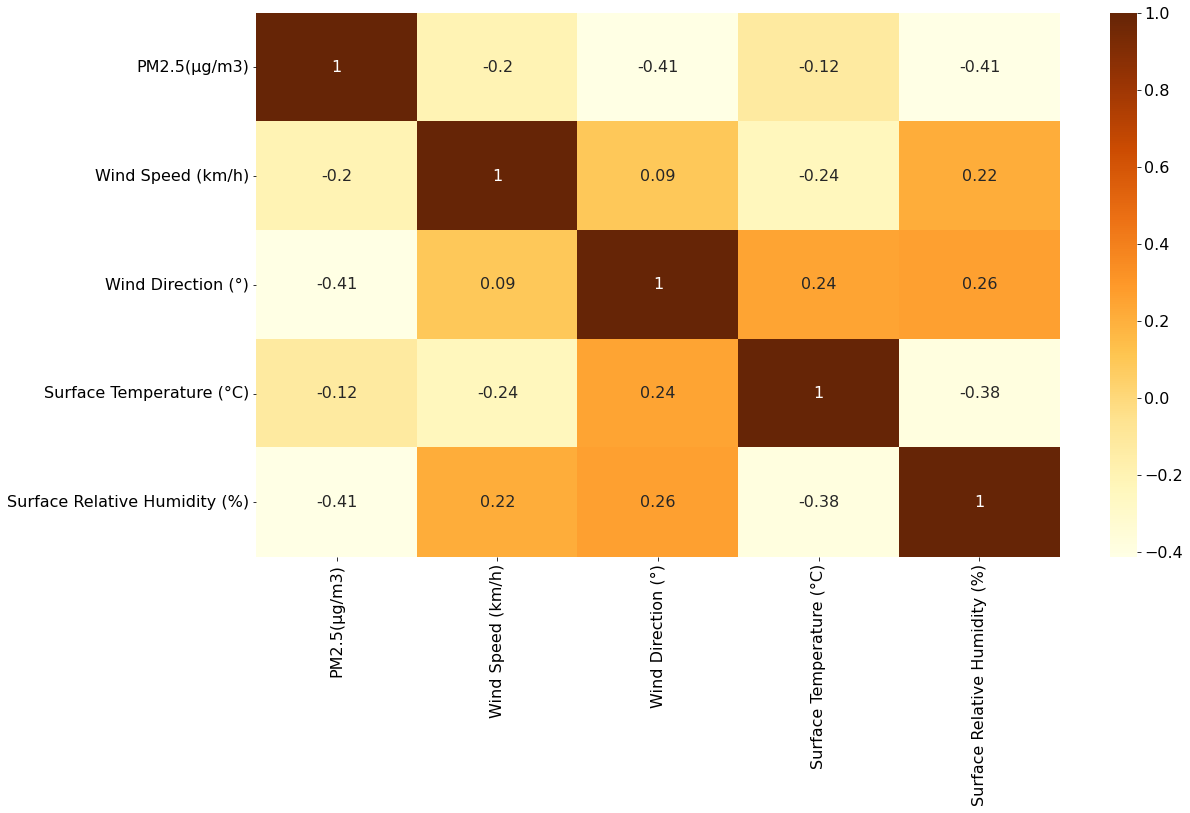

In [ ]:
plt.figure(figsize = (18,10))
plt.rcParams.update({'font.size': 16})
sns.heatmap(df_test[['PM2.5(µg/m3)','Wind Speed (km/h)','Wind Direction (°)','Surface Temperature (°C)','Surface Relative Humidity (%)']].corr(), annot =True, cmap = 'YlOrBr') 

# Explore Data Analysis

In [ ]:
df_all = pd.concat([df_train,df_test])
df_all

,PM2.5(µg/m3),Wind Speed (km/h),Wind Direction (°),Surface Temperature (°C),Surface Relative Humidity (%)
Time,,,,,
2017-07-01 01:00:00,10.0,16,260,27.9,79
2017-07-01 04:00:00,15.0,16,255,27.4,80
2017-07-01 07:00:00,23.0,17,235,28.0,75
2017-07-01 10:00:00,22.0,18,240,31.1,59
2017-07-01 13:00:00,14.0,18,255,33.3,51
...,...,...,...,...,...
2021-07-01 10:00:00,14.0,19,255,30.8,57
2021-07-01 13:00:00,14.0,17,235,32.5,53
2021-07-01 16:00:00,14.0,19,240,32.5,52


Text(0.5, 1.0, 'PM 2.5 during 2017 to 2021')

<Figure size 800x400 with 0 Axes>

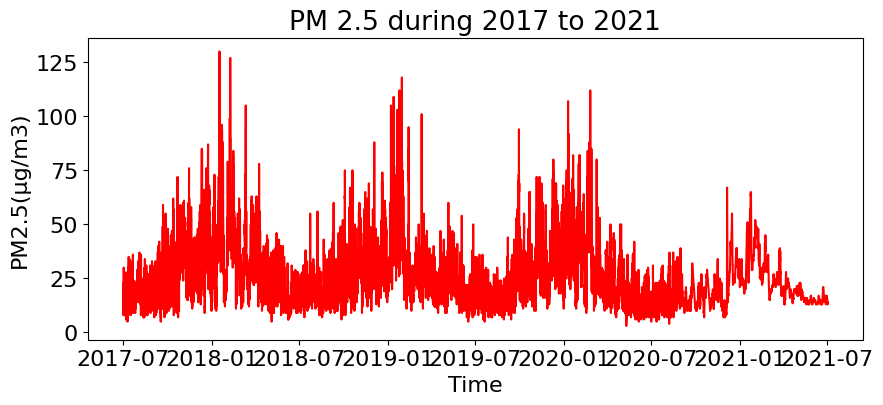

In [ ]:
fig = plt.figure(figsize=(8,4),dpi = 100)
fig,axis = plt.subplots(figsize = (10,4),dpi = 100)
axis.plot(df_all.index,df_all['PM2.5(µg/m3)'],'r-')
axis.set_xlabel('Time')
axis.set_ylabel('PM2.5(µg/m3)')
axis.set_title('PM 2.5 during 2017 to 2021')

There is seasonal effect during Jan-Feb

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

Figure(432x288)


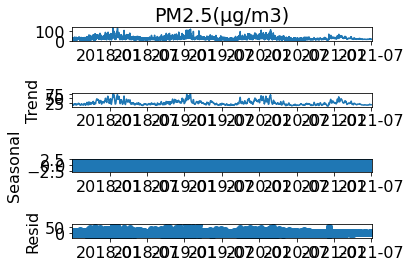

In [ ]:
result = seasonal_decompose(df_all['PM2.5(µg/m3)'])
print(result.plot())


Data were likely seasonal but not stationary ---> RNN will be used to learn complex pattern

# Prepare data

In [ ]:
scaler = MinMaxScaler()
#bkk_train = scaler.fit_transform(df_training)
df_train_ = scaler.fit_transform(df_train)
df_test_ = scaler.fit_transform(df_test)

In [ ]:
scaler.inverse_transform(df_train)

array([[  634.,  1392., 93600.,  1692.,  5321.],
       [  949.,  1392., 91800.,  1662.,  5388.],
       [ 1453.,  1479., 84600.,  1698.,  5053.],
       ...,
       [  571.,  3219., 91800.,  1944.,  4115.],
       [  949.,  3132., 95400.,  1836.,  4651.],
       [  319.,  3045., 97200.,  1782.,  4651.]])

In [ ]:
scale = 1/scaler.scale_
scale

array([ 63.,  87., 360.,  60.,  67.])

Create RNN to look 5 previous time steps

In [ ]:
def prep_to_np(dftrain, dftest):
    train_data = dftrain.copy()
    test_data = dftest.copy()
    
    train = []
    for i in range(len(train_data)-5): 
        train.append(train_data[i: i + 5]) 
    train = np.array(train)

    test = []
    for i in range(len(test_data) - 5): 
        test.append(test_data[i: i + 5]) 
    test = np.array(test)
    
    x_train = train[:,1]
    y_train = train[:,0][:,0]

    x_test = test[:,1]  
    y_test = test[:,0][:,0]
    return [x_train,y_train,x_test,y_test]

In [ ]:
bkk_x_train, bkk_y_train, bkk_x_test, bkk_y_test = prep_to_np(df_train_, df_test_)

In [ ]:
bkk_x_train

array([[0.09448819, 0.18823529, 0.70833333, 0.48803828, 0.8358209 ],
       [0.15748031, 0.2       , 0.65277778, 0.51674641, 0.76119403],
       [0.1496063 , 0.21176471, 0.66666667, 0.66507177, 0.52238806],
       ...,
       [0.07874016, 0.28235294, 0.70833333, 0.51674641, 0.71641791],
       [0.11023622, 0.25882353, 0.70833333, 0.54066986, 0.70149254],
       [0.08661417, 0.28235294, 0.69444444, 0.6507177 , 0.55223881]])

In [ ]:
bkk_y_train

array([0.05511811, 0.09448819, 0.15748031, ..., 0.07874016, 0.07874016,
       0.11023622])

# Build LSTM RNN Model

In [ ]:
from numpy.random import seed
seed(45)
tf.random.set_seed(123)

input_shape = (prev_step, #features)

In [ ]:
modelLSTM = Sequential()

modelLSTM.add(LSTM(units = 64, activation = 'relu', return_sequences = True, input_shape = (5, 1)))
modelLSTM.add(Dropout(0.1))

modelLSTM.add(LSTM(units = 64, activation = 'relu', return_sequences = True))
modelLSTM.add(Dropout(0.1))

modelLSTM.add(LSTM(units = 64, activation = 'relu', return_sequences = True))
modelLSTM.add(Dropout(0.1))

modelLSTM.add(LSTM(units = 64, activation = 'relu', return_sequences = True))
modelLSTM.add(Dropout(0.1))

modelLSTM.add(LSTM(units = 32, activation = 'relu'))
modelLSTM.add(Dropout(0.1))

modelLSTM.add(Dense(units = 1, activation = 'linear'))

modelLSTM.compile(loss='mse',optimizer='adam',metrics=['mse'])

In [ ]:
modelLSTM.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 5, 64)             16896     
                                                                 
 dropout_10 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_11 (LSTM)              (None, 5, 64)             33024     
                                                                 
 dropout_11 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_12 (LSTM)              (None, 5, 64)             33024     
                                                                 
 dropout_12 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_13 (LSTM)              (None, 5, 64)            

## Create callback

In [ ]:
filepath = 'my_best_modelLSTM.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')
earlystopping = EarlyStopping(
    monitor='loss', 
    patience=3, 
    min_delta=0, 
    mode='auto')

reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.2,   
    patience=2, 
    min_lr=1e-4,
    verbose=0)
callbacks = [checkpoint,earlystopping,reduce_lr]

## Training model

In [ ]:
hist = modelLSTM.fit(bkk_x_train, bkk_y_train, epochs=20,callbacks=callbacks)

Epoch 1/20
274/274 [==============================] - 8s 13ms/step - loss: 0.0123 - mse: 0.0123 - lr: 0.0010
Epoch 2/20
274/274 [==============================] - 4s 14ms/step - loss: 0.0053 - mse: 0.0053 - lr: 0.0010
Epoch 3/20
274/274 [==============================] - 5s 18ms/step - loss: 0.0050 - mse: 0.0050 - lr: 0.0010
Epoch 4/20
274/274 [==============================] - 4s 16ms/step - loss: 0.0048 - mse: 0.0048 - lr: 0.0010
Epoch 5/20
274/274 [==============================] - 4s 15ms/step - loss: 0.0048 - mse: 0.0048 - lr: 0.0010
Epoch 6/20
274/274 [==============================] - 4s 13ms/step - loss: 0.0047 - mse: 0.0047 - lr: 0.0010
Epoch 7/20
274/274 [==============================] - 3s 12ms/step - loss: 0.0045 - mse: 0.0045 - lr: 2.0000e-04
Epoch 8/20
274/274 [==============================] - 3s 12ms/step - loss: 0.0045 - mse: 0.0045 - lr: 2.0000e-04
Epoch 9/20
274/274 [==============================] - 3s 11ms/step - loss: 0.0045 - mse: 0.0045 - lr: 2.0000e-04
Epoch 1

In [ ]:
hist_dict = hist.history
hist_dict.keys()

dict_keys(['loss', 'mse', 'lr'])

## Plot loss graph

Text(0, 0.5, 'Loss')

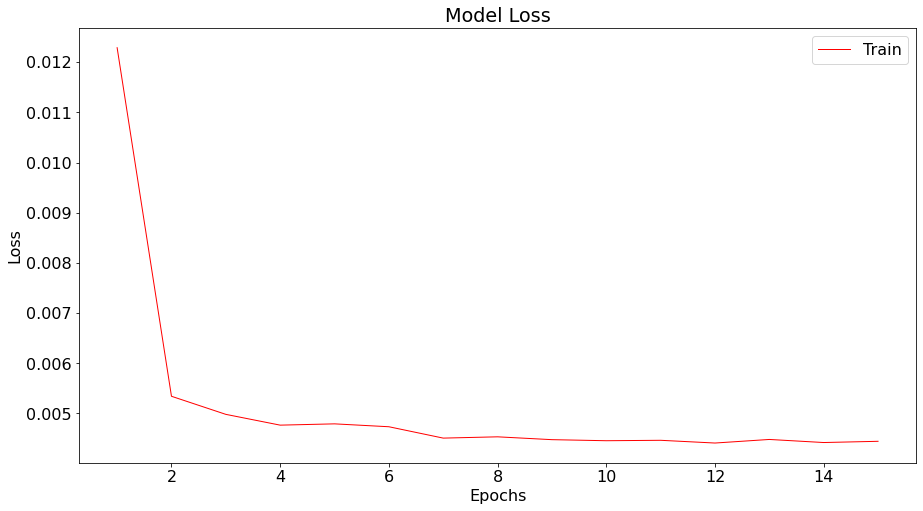

In [ ]:
loss_values = hist_dict['loss']
#val_loss_values = hist_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,8))
plt.plot(epochs, loss_values, color='red', linewidth=1, markersize=2)
#plt.plot(epochs, val_loss_values, color='blue', linewidth=1, markersize=2)
plt.title('Model Loss')
plt.legend(['Train'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:
modelLSTM.save_weights('bkk_pm25_forecast.h5')

In [ ]:
modelLSTM.load_weights('bkk_pm25_forecast.h5')

### Model Prediction

In [ ]:
bkk_x_test.shape,bkk_y_test.shape

((2923, 5), (2923,))

In [ ]:
bkk_y_test

array([0.06349206, 0.06349206, 0.14285714, ..., 0.17460317, 0.17460317,
       0.15873016])

In [ ]:
y_pred = modelLSTM.predict(bkk_x_test)

92/92 [==============================] - 1s 3ms/step


In [ ]:
y_pred

array([[0.09597206],
       [0.12718216],
       [0.10615493],
       ...,
       [0.17363945],
       [0.16419418],
       [0.16656148]], dtype=float32)

In [ ]:
scaler.scale_

array([0.01587302, 0.01149425, 0.00277778, 0.01666667, 0.01492537])

In [ ]:
scale = 1/scaler.scale_[0]
scale

63.0

In [ ]:
bkk_y_test = bkk_y_test*scale

In [ ]:
y_pred = y_pred*scale

In [ ]:
bkk_y_test

array([ 4.,  4.,  9., ..., 11., 11., 10.])

In [ ]:
np.amin(bkk_y_test)

0.0

During inverse transformation, `bkk_y_test` contain the value of zero, which will be error for MAPE evaluator.

Thus, reimport test dataset before minmax transformation.

In [ ]:
test_data = df_test.to_numpy()
test = []
for i in range(len(test_data) - 5): 
    test.append(test_data[i: i + 5]) 
test = np.array(test)
y_test = test[:,0][:,0]

In [ ]:
y_test

array([ 8.,  8., 13., ..., 15., 15., 14.])

In [ ]:
y_test.shape

(2923,)

In [ ]:
y_pred.shape

(2923, 1)

### Model Evaluation

In [ ]:
import math
from sklearn.metrics import mean_squared_error

def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

print( 'MAPE =', MAPE(y_test, y_pred[:,0]) )
print( 'RMSE =', math.sqrt(mean_squared_error(y_test, y_pred[:,0])) )

MAPE = 21.882331563605447
RMSE = 5.370285472129528


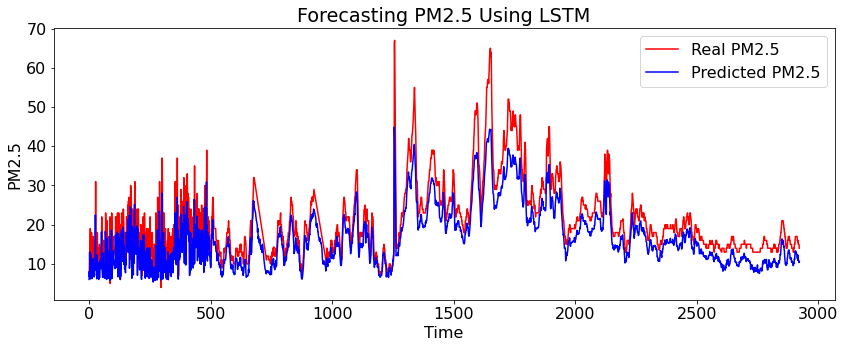

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real PM2.5')
plt.plot(y_pred, color = 'blue', label = 'Predicted PM2.5')
plt.title('Forecasting PM2.5 Using LSTM')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

# Build GRU RNN Model

In [ ]:
from tensorflow.keras.layers import GRU

In [ ]:
from numpy.random import seed
seed(45)
tf.random.set_seed(123)

In [ ]:
modelGRU = Sequential()

modelGRU.add(GRU(units = 64, activation = 'relu', return_sequences = True, input_shape = (5, 1)))
modelGRU.add(Dropout(0.1))

modelGRU.add(GRU(units = 64, activation = 'relu', return_sequences = True))
modelGRU.add(Dropout(0.1))

modelGRU.add(GRU(units = 64, activation = 'relu', return_sequences = True))
modelGRU.add(Dropout(0.1))

modelGRU.add(GRU(units = 64, activation = 'relu', return_sequences = True))
modelGRU.add(Dropout(0.1))

modelGRU.add(GRU(units = 32, activation = 'relu'))
modelGRU.add(Dropout(0.1))

modelGRU.add(Dense(units = 1, activation = 'linear'))

modelGRU.compile(loss='mse',optimizer='adam',metrics=['mse'])

In [ ]:
modelGRU.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5, 64)             12864     
                                                                 
 dropout_15 (Dropout)        (None, 5, 64)             0         
                                                                 
 gru_1 (GRU)                 (None, 5, 64)             24960     
                                                                 
 dropout_16 (Dropout)        (None, 5, 64)             0         
                                                                 
 gru_2 (GRU)                 (None, 5, 64)             24960     
                                                                 
 dropout_17 (Dropout)        (None, 5, 64)             0         
                                                                 
 gru_3 (GRU)                 (None, 5, 64)            

## Create callback

In [ ]:
filepath = 'my_best_modelGRU.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')
earlystopping = EarlyStopping(
    monitor='loss', 
    patience=3, 
    min_delta=0, 
    mode='auto')

reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.2,   
    patience=2, 
    min_lr=1e-4,
    verbose=0)
callbacks = [checkpoint,earlystopping,reduce_lr]

## Training model

In [ ]:
hist = modelGRU.fit(bkk_x_train, bkk_y_train, epochs=20,callbacks=callbacks)

Epoch 1/20
274/274 [==============================] - 10s 12ms/step - loss: 0.0139 - mse: 0.0139 - lr: 0.0010
Epoch 2/20
274/274 [==============================] - 4s 14ms/step - loss: 0.0058 - mse: 0.0058 - lr: 0.0010
Epoch 3/20
274/274 [==============================] - 4s 14ms/step - loss: 0.0051 - mse: 0.0051 - lr: 0.0010
Epoch 4/20
274/274 [==============================] - 3s 12ms/step - loss: 0.0049 - mse: 0.0049 - lr: 0.0010
Epoch 5/20
274/274 [==============================] - 3s 12ms/step - loss: 0.0048 - mse: 0.0048 - lr: 0.0010
Epoch 6/20
274/274 [==============================] - 3s 12ms/step - loss: 0.0048 - mse: 0.0048 - lr: 0.0010
Epoch 7/20
274/274 [==============================] - 3s 12ms/step - loss: 0.0046 - mse: 0.0046 - lr: 0.0010
Epoch 8/20
274/274 [==============================] - 3s 11ms/step - loss: 0.0046 - mse: 0.0046 - lr: 0.0010
Epoch 9/20
274/274 [==============================] - 3s 11ms/step - loss: 0.0046 - mse: 0.0046 - lr: 0.0010
Epoch 10/20
274/27

In [ ]:
hist_dict = hist.history
hist_dict.keys()

dict_keys(['loss', 'mse', 'lr'])

## Plot loss graph

Text(0, 0.5, 'Loss')

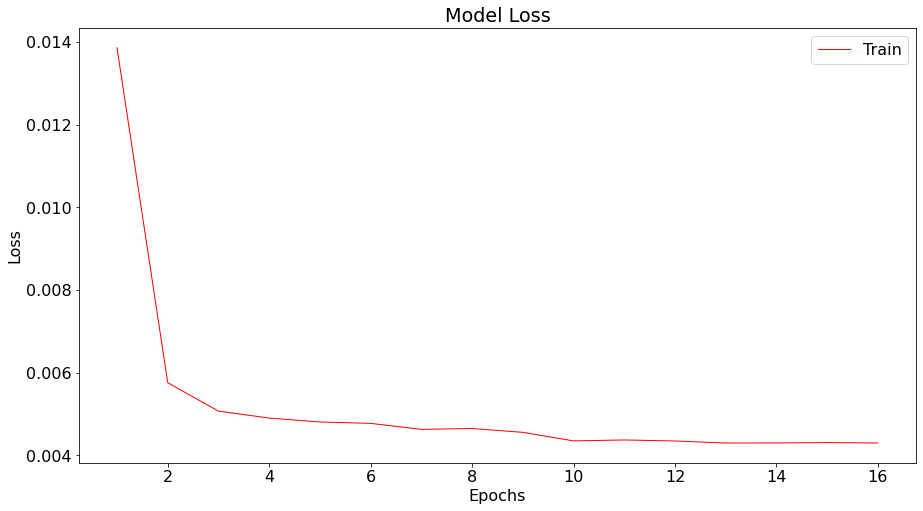

In [ ]:
loss_values = hist_dict['loss']
#val_loss_values = hist_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,8))
plt.plot(epochs, loss_values, color='red', linewidth=1, markersize=2)
#plt.plot(epochs, val_loss_values, color='blue', linewidth=1, markersize=2)
plt.title('Model Loss')
plt.legend(['Train'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:
modelGRU.save_weights('bkk_pm25_forecast.h5')

In [ ]:
modelGRU.load_weights('bkk_pm25_forecast.h5')

### Model Prediction

In [ ]:
bkk_x_test.shape,bkk_y_test.shape

((2923, 5), (2923,))

In [ ]:
bkk_y_test

array([ 4.,  4.,  9., ..., 11., 11., 10.])

In [ ]:
y_pred = modelGRU.predict(bkk_x_test)

92/92 [==============================] - 1s 3ms/step


In [ ]:
y_pred

array([[0.11115614],
       [0.13951461],
       [0.12284192],
       ...,
       [0.19255209],
       [0.1728699 ],
       [0.17624867]], dtype=float32)

In [ ]:
scaler.scale_

array([0.01587302, 0.01149425, 0.00277778, 0.01666667, 0.01492537])

In [ ]:
scale = 1/scaler.scale_[0]
scale

63.0

In [ ]:
y_pred = y_pred*scale

In [ ]:
test_data = df_test.to_numpy()
test = []
for i in range(len(test_data) - 5): 
    test.append(test_data[i: i + 5]) 
test = np.array(test)
y_test = test[:,0][:,0]
y_test

array([ 8.,  8., 13., ..., 15., 15., 14.])

### Model Evaluation

In [ ]:
import math
from sklearn.metrics import mean_squared_error

def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

print( 'MAPE =', MAPE(y_test, y_pred) )
print( 'RMSE =', math.sqrt(mean_squared_error(y_test, y_pred[:,0])) )

MAPE = 46.023246881259496
RMSE = 4.767561510599376


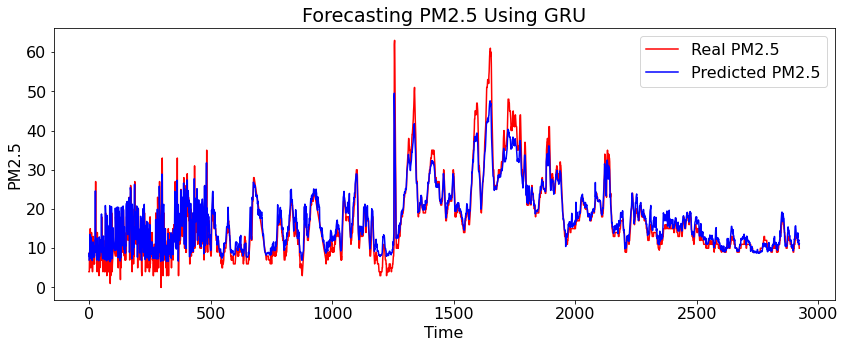

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(bkk_y_test, color = 'red', label = 'Real PM2.5')
plt.plot(y_pred, color = 'blue', label = 'Predicted PM2.5')
plt.title('Forecasting PM2.5 Using GRU')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()